<a href="https://colab.research.google.com/github/diyoadisuta/KomposKita/blob/machine_learning/CAPSTONEMODEL_KOMPOSKITA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **KLASIFIKASI BAHAN SAMPAH KOMPOS MENGGUNAKAN MOBILENETV2**

Pada proyek ini kami membuat model untuk klasifikasi bahan sampah layak kompos dan tidak layak kompos menggunakan tiga kelas:

1.   Sampah Organik Basah (LAYAK KOMPOS)
2.   Sampah Organik Kering (LAYAK KOMPOS)
3.   Sampah Tidak Layak Kompos

Proyek menggunakan model yang dikerjakan oleh tim *machine learning* yang terdiri atas:
- Dewi Puspita - MC834D5X1362
- Mochammad Syafiq Ilallah - MC006D5Y2189
- Muhammad Fauzani Akbar - MC528D5Y0070

Dataset yang digunakan terdiri dari 12.464 data gambar sampah, dengan rincian sebagai berikut:
- 4.451 data sampah organik basah
- 4.009 data sampah organik kering
- 4.004 sampah tidak layak kompos

## IMPORT LIBRARY

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.5 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
google-cloud-bigquery 3.32.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [36]:
import io
import os
import shutil
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflowjs as tfjs
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from PIL import Image
from collections import defaultdict
from keras import Input, Model
from enum import auto

# Library MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Sequential
from sklearn.utils import class_weight

# Library untuk mengambil dataset
from google.colab import drive, files

## DATA LOADING

In [9]:
# Path dataset asli dan target output split (di dalam Google Drive)
original_dataset_path = "/content/drive/MyDrive/KomposKita/Dataset"

In [10]:
# Kelas yang akan digunakan
selected_classes = ['Sampah Organik Basah (LAYAK KOMPOS)','Sampah Organik Kering (LAYAK KOMPOS)','Sampah Tidak Layak Kompos']

In [11]:
image_counts = {}
widths = []
heights = []

# Iterasi gambar tiap kelas yang dipilih
for cls in selected_classes:
    class_path = os.path.join(original_dataset_path, cls) # Path untuk menuju setiap kelas yang akan digunakan
    image_list = [img for img in os.listdir(class_path) if img.lower().endswith(('.jpg', '.jpeg', '.png'))] # Mengambil seluruh file gambar dalam berbagai tipe dari folder kelas yang digunakan
    image_counts[cls] = len(image_list) # Menyimpan jumlah gambar

    # Iterasi setiap gambar dari list
    for img_name in image_list:
        img_path = os.path.join(class_path, img_name) # Membuat path lengkap ke path gambar

        # Membuka gambar di dalam file dataset
        try:
            with Image.open(img_path) as img:
                widths.append(img.size[0])
                heights.append(img.size[1])

        # Aksi ketika gagal mengambil gambar
        except:
            continue

In [12]:
# Menampilkan jumlah gambar per kelas
for cls, count in image_counts.items():
    print(f"{cls}: {count} gambar")

Sampah Organik Basah (LAYAK KOMPOS): 4451 gambar
Sampah Organik Kering (LAYAK KOMPOS): 4009 gambar
Sampah Tidak Layak Kompos: 4004 gambar


In [13]:
# Statistik ukuran
print(f"Rata-rata ukuran gambar: {np.mean(widths):.2f} x {np.mean(heights):.2f}")
print(f"Ukuran minimum: {min(widths)} x {min(heights)}")
print(f"Ukuran maksimum: {max(widths)} x {max(heights)}")

Rata-rata ukuran gambar: 850.39 x 774.99
Ukuran minimum: 80 x 95
Ukuran maksimum: 5472 x 4160


In [16]:
# Parameter gambar dan training
img_size = (512, 512)  # Ukuran gambar setelah resize
batch_size = 16
num_classes = 3

## DATA SPLITING

In [17]:
# Buat folder train/val/test
for split in ['train', 'val', 'test']:
    for cls in selected_classes:
        os.makedirs(os.path.join(target_base_dir, split, cls), exist_ok=True)

# Proses tiap kelas
for cls in selected_classes:
    cls_folder = os.path.join(original_dataset_path, cls)
    images = [img for img in os.listdir(cls_folder) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]

    # Split data
    train_imgs, temp_imgs = train_test_split(images, test_size=0.2, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

    def process_and_save(images_list, split_type):
        for img_name in images_list:
            src = os.path.join(cls_folder, img_name)
            dst = os.path.join(target_base_dir, split_type, cls, img_name)
            try:
                # Resize dan simpan ulang
                with Image.open(src) as img:
                    img = img.convert("RGB")  # Jaga agar konsisten channel
                    img = img.resize(img_size)
                    img.save(dst)
            except Exception as e:
                print(f"Error processing {src}: {e}")

    # Simpan semua hasil resize ke folder target
    process_and_save(train_imgs, 'train')
    process_and_save(val_imgs, 'val')
    process_and_save(test_imgs, 'test')

print(" Dataset sudah diresize dan dipisahkan ke train/val/test.")


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Error processing /content/drive/MyDrive/KomposKita/Dataset/Sampah Organik Kering (LAYAK KOMPOS)/ranting_328.jpg: cannot identify image file '/content/drive/MyDrive/KomposKita/Dataset/Sampah Organik Kering (LAYAK KOMPOS)/ranting_328.jpg'
Error processing /content/drive/MyDrive/KomposKita/Dataset/Sampah Organik Kering (LAYAK KOMPOS)/roti_207.jpg: cannot identify image file '/content/drive/MyDrive/KomposKita/Dataset/Sampah Organik Kering (LAYAK KOMPOS)/roti_207.jpg'
 Dataset sudah diresize dan dipisahkan ke train/val/test.


## MOBILENETV2

### Parameter

In [21]:
# Folder target untuk menyimpan dataset yang sudah diresize
dataset_dir = "/content/data_split"

### Data Generator

In [22]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/data_split/train", # Path ke folder data training
    label_mode = 'categorical', # Label dibuat one-hot encoded (untuk klasifikasi multi-class)
    image_size = img_size, # Ukuran gambar diubah menjadi ukuran img_size
    batch_size = batch_size # Ukuran batch diubah menjadi ukuran batch_size
)

val_data = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/data_split/val", # Path ke folder data validasi
    label_mode = 'categorical',
    image_size = img_size,
    batch_size = batch_size
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/data_split/test", # Path ke folder data testing
    label_mode = 'categorical',
    image_size = img_size,
    batch_size = batch_size
)

Found 9968 files belonging to 3 classes.
Found 1246 files belonging to 3 classes.
Found 1248 files belonging to 3 classes.


### Preprocessing

Tahap ini dilakukan untuk menerapkan preprocessing ke data gambar sebelum dikirim ke model. Dengan menggunakan fungsi map() yang digunakan untuk menerapkan fungsi ke setiap batch data.

In [23]:
train_data = train_data.map(lambda x, y: (preprocess_input(x), y)) # Preprocessing gambar untuk data train
val_data = val_data.map(lambda x, y: (preprocess_input(x), y)) # Preprocessing gambar untuk data validasi
test_data = test_data.map(lambda x, y: (preprocess_input(x), y)) # Preprocessing gambar untuk gambar pengujian

In [24]:
autotune = tf.data.AUTOTUNE #TensorFlow akan otomatis mengatur jumlah buffer prefetch optimaly
train_data = train_data.prefetch(buffer_size=autotune) # Prefetch data train agar proses training lebih cepat
val_data = val_data.prefetch(buffer_size=autotune) # Prefetch data validation agar proses validasi lebih cepat
test_data = test_data.prefetch(buffer_size=autotune) # Prefetch data test agar proses pengujian lebih cepat

## BASE MODEL

In [25]:
img_shape = img_size + (3,) # Menambahkan RGB (3 channel warna) pada img_size
base_model = MobileNetV2(input_shape=img_shape, include_top=False, weights='imagenet')
base_model.trainable = False

<ipython-input-25-ed324a2d7774>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=img_shape, include_top=False, weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [26]:
# ==== BASE MODEL ====
base_model = MobileNetV2(input_shape=img_shape, include_top=False, weights='imagenet')
base_model.trainable = False  # awalnya freeze dulu

# ==== FULL MODEL ====
model = models.Sequential([
    base_model, # Menggunakan base_model sebagai fitur ekstraksi
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

<ipython-input-26-a3adbdc658d7>:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=img_shape, include_top=False, weights='imagenet')


In [27]:
# Digunakan untuk stop akurasi jika memenuhi target
class stop_in_accuracy(tf.keras.callbacks.Callback):
  def __init__(self, acc_threshold=0.95):
      super().__init__()
      self.acc_threshold = acc_threshold

  def on_epoch_end(self, epoch, logs= None):
    acc = logs.get("accuracy")
    val_acc = logs.get("val_accuracy")
    if acc is not None and val_acc is not None:
      if acc >= self.acc_threshold and val_acc >= self.acc_threshold:
        print(f"Target tercapa! akurasi dan val_akurasi > {self.acc_threshold*100:.0f}%. Stop training.")
        self.model.stop_training = True

In [30]:
callbacks = [
    stop_in_accuracy(acc_threshold=0.95),
    ReduceLROnPlateau(patience=3, factor=0.5),
    ModelCheckpoint("best_model.h5", save_best_only=True)
]

In [31]:
history = model.fit(
    train_data,
    validation_data = val_data,
    epochs = 10,
    callbacks = callbacks
)

Epoch 1/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8048 - loss: 0.5892

623/623 ━━━━━━━━━━━━━━━━━━━━ 61s 98ms/step - accuracy: 0.8049 - loss: 0.5892 - val_accuracy: 0.8820 - val_loss: 0.4232 - learning_rate: 1.0000e-04
Epoch 2/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8716 - loss: 0.4154

623/623 ━━━━━━━━━━━━━━━━━━━━ 64s 69ms/step - accuracy: 0.8716 - loss: 0.4153 - val_accuracy: 0.9053 - val_loss: 0.3369 - learning_rate: 1.0000e-04
Epoch 3/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.8991 - loss: 0.3331

623/623 ━━━━━━━━━━━━━━━━━━━━ 43s 69ms/step - accuracy: 0.8991 - loss: 0.3331 - val_accuracy: 0.9141 - val_loss: 0.2874 - learning_rate: 1.0000e-04
Epoch 4/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9146 - loss: 0.2896

623/623 ━━━━━━━━━━━━━━━━━━━━ 44s 70ms/step - accuracy: 0.9146 - loss: 0.2896 - val_accuracy: 0.9230 - val_loss: 0.2549 - learning_rate: 1.0000e-04
Epoch 5/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9236 - loss: 0.2542

623/623 ━━━━━━━━━━━━━━━━━━━━ 81s 69ms/step - accuracy: 0.9236 - loss: 0.2542 - val_accuracy: 0.9294 - val_loss: 0.2317 - learning_rate: 1.0000e-04
Epoch 6/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.9289 - loss: 0.2348

623/623 ━━━━━━━━━━━━━━━━━━━━ 43s 69ms/step - accuracy: 0.9289 - loss: 0.2348 - val_accuracy: 0.9390 - val_loss: 0.2132 - learning_rate: 1.0000e-04
Epoch 7/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9338 - loss: 0.2162

623/623 ━━━━━━━━━━━━━━━━━━━━ 44s 70ms/step - accuracy: 0.9338 - loss: 0.2162 - val_accuracy: 0.9438 - val_loss: 0.1993 - learning_rate: 1.0000e-04
Epoch 8/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9376 - loss: 0.2082

623/623 ━━━━━━━━━━━━━━━━━━━━ 44s 70ms/step - accuracy: 0.9376 - loss: 0.2082 - val_accuracy: 0.9470 - val_loss: 0.1885 - learning_rate: 1.0000e-04
Epoch 9/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9398 - loss: 0.1896

623/623 ━━━━━━━━━━━━━━━━━━━━ 44s 71ms/step - accuracy: 0.9398 - loss: 0.1896 - val_accuracy: 0.9478 - val_loss: 0.1790 - learning_rate: 1.0000e-04
Epoch 10/10
623/623 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.9436 - loss: 0.1799

623/623 ━━━━━━━━━━━━━━━━━━━━ 44s 71ms/step - accuracy: 0.9436 - loss: 0.1799 - val_accuracy: 0.9502 - val_loss: 0.1721 - learning_rate: 1.0000e-04


In [32]:
# ==== EVALUASI ====
loss, acc = model.evaluate(test_data)
print(f"\nTest Accuracy: {acc:.2%}")

78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.9529 - loss: 0.1617

Test Accuracy: 96.15%


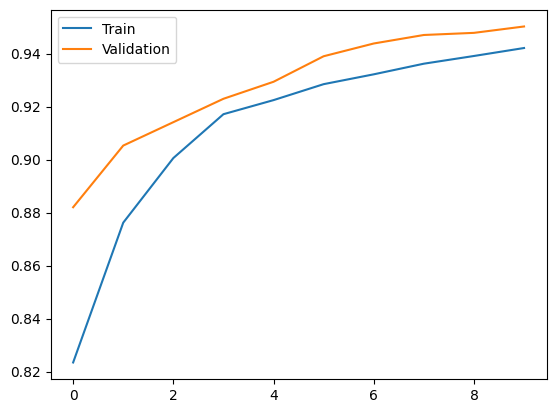

In [41]:
# Menampilkan grafik histogram accuracy dan val_accuracy
plt.plot(history.history['accuracy'],label='Train')
plt.plot(history.history['val_accuracy'],label='Validation')
plt.legend()

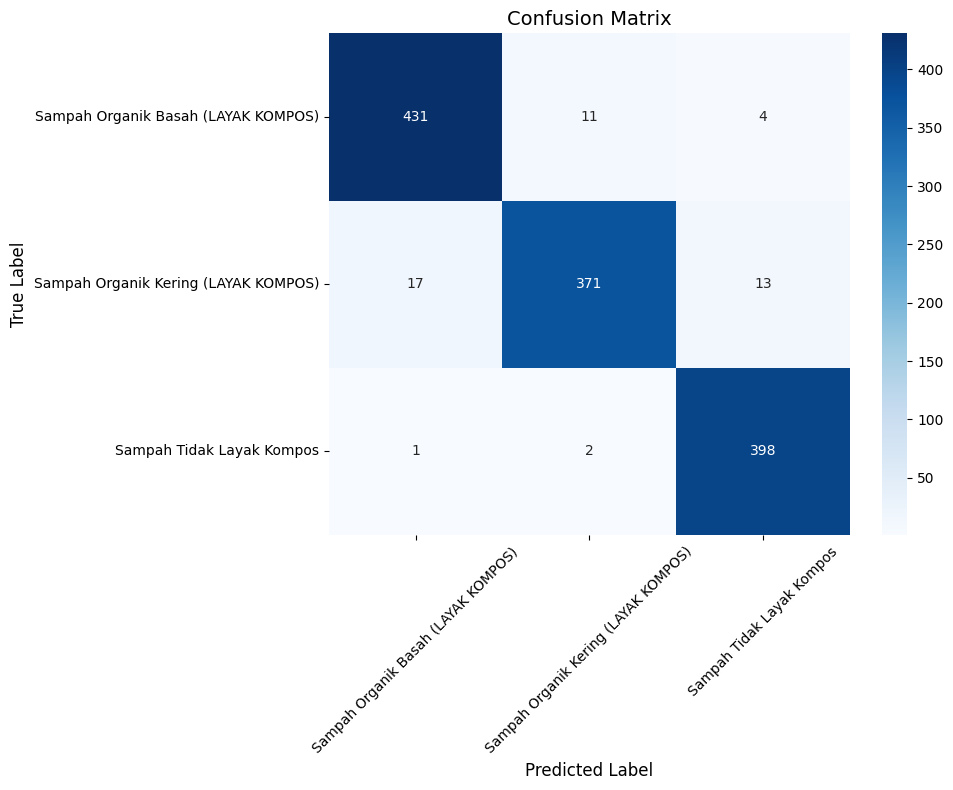


Classification Report:
                                      precision    recall  f1-score   support

 Sampah Organik Basah (LAYAK KOMPOS)       0.96      0.97      0.96       446
Sampah Organik Kering (LAYAK KOMPOS)       0.97      0.93      0.95       401
           Sampah Tidak Layak Kompos       0.96      0.99      0.98       401

                            accuracy                           0.96      1248
                           macro avg       0.96      0.96      0.96      1248
                        weighted avg       0.96      0.96      0.96      1248



In [34]:
# Menampilkan confusion matrix
from sklearn.metrics import confusion_matrix, classification_report

def plot_confusion_matrix(model, test_data):
  y_ori = []
  y_pred = []

  class_names = sorted(['Sampah Organik Basah (LAYAK KOMPOS)',
                       'Sampah Organik Kering (LAYAK KOMPOS)',
                       'Sampah Tidak Layak Kompos'])
  for images, labels in test_data:
    y_ori.extend(np.argmax(labels.numpy(), axis=1))
    predictions = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(predictions, axis=1))

  cm = confusion_matrix(y_ori, y_pred)
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
              xticklabels=class_names,
              yticklabels=class_names)
  plt.title('Confusion Matrix', fontsize=14)
  plt.xlabel('Predicted Label', fontsize=12)
  plt.ylabel('True Label', fontsize=12)
  plt.xticks(rotation=45)
  plt.yticks(rotation=0)
  plt.tight_layout()
  plt.show()

  print("\nClassification Report:")
  print(classification_report(y_ori, y_pred, target_names=class_names))

plot_confusion_matrix(model, test_data)

📤 Silakan upload gambar sampah untuk diprediksi:


Saving 77dcca76-5c76-4ccf-b89e-c236dfa1ab57.jpg to 77dcca76-5c76-4ccf-b89e-c236dfa1ab57.jpg


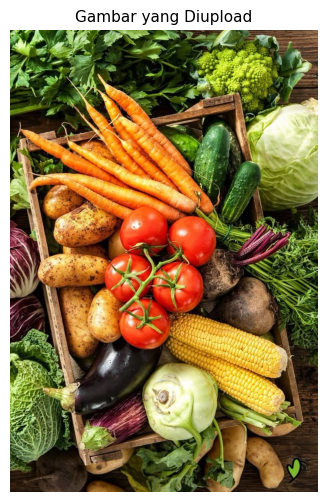

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step

🔍 Hasil Prediksi:
♣️♣️♣️♣️♣️♣️♣️♣️♣️♣️♣️♣️♣️♣️♣️
➡ Sampah Organik Basah (LAYAK KOMPOS)
♣️♣️♣️♣️♣️♣️♣️♣️♣️♣️♣️♣️♣️♣️♣️

Keterangan:
- 'LAYAK KOMPOS' berarti sampah bisa diolah menjadi kompos 🗿
- 'Tidak Layak Kompos' berarti sampah harus dibuang ke tempat sampah umum 🥶


In [40]:
def upload_and_predict(model):
    # Upload gambar
    uploaded = files.upload()

    # Daftar kelas yang ada
    class_names = ['Sampah Organik Basah (LAYAK KOMPOS)',
                   'Sampah Organik Kering (LAYAK KOMPOS)',
                   'Sampah Tidak Layak Kompos']
    for namafile in uploaded.keys():
      try:
        img = Image.open(io.BytesIO(uploaded[namafile]))
        # Tampilkan gambar
        plt.figure(figsize=(6,6))
        plt.imshow(img)
        plt.title("Gambar yang Diupload", fontsize=11)
        plt.axis('off')
        plt.show()

        # preprocess gambar
        img = img.convert('RGB').resize((512,512))
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        img_array = preprocess_input(img_array)
        img_array = np.expand_dims(img_array, axis=0)

        # Lakukan prediksi
        predictions = model.predict(img_array)
        predicted_class_idx = np.argmax(predictions)

        #MENAMPILKAN KELAS DENGAN PREDIKSI TERTINGGI
        print("\n🔍 Hasil Prediksi:")
        print("♣️"*15)
        print(f"➡ {class_names[predicted_class_idx]}")
        print("♣️"*15)
        print("\nKeterangan:")
        print("- 'LAYAK KOMPOS' berarti sampah bisa diolah menjadi kompos 🗿")
        print("- 'Tidak Layak Kompos' berarti sampah harus dibuang ke tempat sampah umum 🥶")
      except Exception as e:
        print(f"Error processing image: {e}")


# Jalankan fungsi
print("📤 Silakan upload gambar sampah untuk diprediksi:")
upload_and_predict(model)

## **Convert Model ke TFJS**

In [42]:
tfjs.converters.save_keras_model(model, '/content/drive/MyDrive/KomposKita/tfjs_model')

failed to lookup keras version from the file,
    this is likely a weight only file
